# AutoGluon Image Classification

### Prerequisites

훈련 이미지 준비. k개의 클래스(이진 분류일 경우 2개)에 대한 이미지를 아래 폴더와 같이 준비한다. 
```
├── [YOUR-TASK-DIR-RAW]
│   ├── [CLASS-1]
│   ├── [CLASS-2]
│   ├── ...
│   └── [CLASS-k]
```

본 샘플 코드의 예시는 아래와 같다.
```
├── abnormal_box_raw
│   ├── abnormal
│   └── normal

```

### References
- AutoGluon Image Prediction: https://auto.gluon.ai/stable/tutorials/multimodal/image_prediction/beginner_image_cls.html

### Install packages

In [1]:
# !pip install -q autogluon==0.7.1b20230513

In [2]:
%load_ext autoreload
%autoreload 2
import os
import random
import timm
import uuid
from glob import glob
import pandas as pd
from scripts.utils import get_classes, save_classes_dict, load_classes_dict, get_dataset_files, get_class_weights, show_classification_result
from autogluon.multimodal import MultiModalPredictor

In [3]:
raw_dir = "abnormal_box_raw"
task = "abnormal_box"
!rm -rf AutogluonModels tmp {task}
classes, classes_dict = get_classes(raw_dir)
num_classes = len(classes)
train_ratio = 0.8
imbalanced_dataset = False
print(classes_dict)

{0: 'normal', 1: 'abnormal'}


### Prepare dataset

AutoGluon MultiModalPredictor의 Image Classification을 위한 데이터셋 경로를 구성한다.
```
├── [YOUR-TASK-DIR]
│   ├── train
│   │   ├── [CLASS-1]
│   │   ├── [CLASS-2]
│   │   ├── ...
│   │   └── [CLASS-k]
│   └── test
│       ├── [CLASS-1]
│       ├── [CLASS-2]
│       ├── ...
│       └── [CLASS-k]
```


본 샘플 코드의 예시는 아래와 같다.
```
├── abnormal_box_raw
│   ├── train
│   │   ├── abnormal
│   │   └── normal
│   └── test
│       ├── abnormal
│       └── normal

```

In [4]:
train_df = pd.DataFrame({'image': [], 'label': []})
test_df = pd.DataFrame({'image': [], 'label': []})

for class_num, class_str in classes_dict.items():

    img_raw_path = os.path.join(raw_dir, class_str)
    img_train_path = os.path.join(task, 'train', class_str)
    img_test_path = os.path.join(task, 'test', class_str)

    files = glob(f'{img_raw_path}/*.jpg') + glob(f'{img_raw_path}/*.jpeg') + glob(f'{img_raw_path}/*.png') + glob(f'{img_raw_path}/*.bmp')
    num_files = len(files)
    random.shuffle(files)

    num_train_files = int(num_files * train_ratio)
    num_test_files = num_files - num_train_files
    train_files = files[:num_train_files]
    test_files = files[num_train_files:]

    train_dataset_files = get_dataset_files(train_files, img_train_path)
    test_dataset_files = get_dataset_files(test_files, img_test_path)

    train_df_ = pd.DataFrame(train_files, columns=['image'])
    train_df_['label'] = class_num
    train_df = pd.concat([train_df, train_df_], ignore_index=True)

    test_df_ = pd.DataFrame(test_files, columns=['image'])
    test_df_['label'] = class_num
    test_df = pd.concat([test_df, test_df_], ignore_index=True)

train_df = train_df.astype({'label': 'int32'})
test_df = test_df.astype({'label': 'int32'})

# Save Dataframe
train_df.to_csv(f"{task}/train.csv", index=None)
test_df.to_csv(f"{task}/test.csv", index=None)

### Setup hyperparameters
- Imbalanced Dataset일 경우 focal loss 손실함수를 적용할 수 있다. Accuracy 지표보다는 AUPRC, AUROC 지표를 중점적으로 파악해야 한다.


In [5]:
hyperparameters={
    #"model.timm_image.checkpoint_name": backbone,
    "optimization.learning_rate": 3e-4,
    "env.per_gpu_batch_size": 16,  # decrease it when model is large
    "optimization.max_epochs": 30,  # max number of training epochs, note that we may early stop before this based on validation setting
    "optimization.check_val_every_n_epoch": 10,  # Do k validation each k epochs
    "optimization.log_every_n_steps": 40,
    "optimization.patience": 3,  # Early stop after k consective validations are not the best
    "data.mixup.turn_on": True
}

if imbalanced_dataset:
    weights = get_class_weights(train_df)
    hyperparameters_imbalanced={
        "optimization.loss_function": "focal_loss",
        "optimization.focal_loss.alpha": weights,
        "optimization.focal_loss.reduction": "sum",
    }
    hyperparameters = {**hyperparameters, **hyperparameters_imbalanced}

In [6]:
avail_pretrained_models = timm.list_models(pretrained=True)
model_path = f"./tmp/{task}-{uuid.uuid4().hex}"
predictor = MultiModalPredictor(
    label="label", 
    path=model_path,
)

predictor.fit(
    train_data=train_df, # you can use train_data_byte as well
    hyperparameters=hyperparameters
    #time_limit=30, # seconds
) # you can trust the default config, e.g., we use a `swin_base_patch4_window7_224` model

Global seed set to 0
AutoMM starts to create your model. ✨

- Model will be saved to "/home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467".

- Validation metric is "roc_auc".

- To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467
    ```

Enjoy your coffee, and let AutoMM do the job ☕☕☕ Learn more at https://auto.gluon.ai

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defin

Sanity Checking: 0it [00:00, ?it/s]

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=40). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 9, global step 9: 'val_roc_auc' reached 0.91270 (best 0.91270), saving model to '/home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467/epoch=9-step=9.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 10: 'val_roc_auc' reached 0.98413 (best 0.98413), saving model to '/home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467/epoch=9-step=10.ckpt' as top 3


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 19: 'val_roc_auc' reached 1.00000 (best 1.00000), saving model to '/home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467/epoch=19-step=19.ckpt' as top 3
Start to fuse 3 checkpoints via the greedy soup algorithm.
You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

AutoMM has created your model 🎉🎉🎉

- To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467")
    ```

- You can open a terminal and launch Tensorboard to visualize the training log:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /home/ec2-user/SageMaker/autogluon-imgclass-with-sagemaker-example/tmp/abnormal_box-42d43e2e1c6841b8841fac7b1a4be467
    ```

- If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub: https://github.com/autogluon/autogluon




In [7]:
predictor.evaluate(test_df, metrics=["accuracy", "f1", "precision", "recall", "roc_auc"])

You are using a CUDA device ('NVIDIA A10G') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Predicting: 0it [00:00, ?it/s]

{'accuracy': 1.0, 'f1': 1.0, 'precision': 1.0, 'recall': 1.0, 'roc_auc': 1.0}

In [8]:
import numpy as np
from glob import glob

test_path = f"{task}/test/normal" 
test_files = glob(f'{test_path}/*.jpg') + glob(f'{test_path}/*.jpeg') + glob(f'{test_path}/*.png') + glob(f'{test_path}/*.bmp')
num_test_files = len(test_files)

In [9]:
test_idx = np.random.randint(num_test_files)
img_path = test_files[test_idx]
pred_cls = predictor.predict(img_path)[0]
print(f"predicted class index: {pred_cls}, class str: {classes_dict[pred_cls]}")

predicted class index: 0, class str: normal


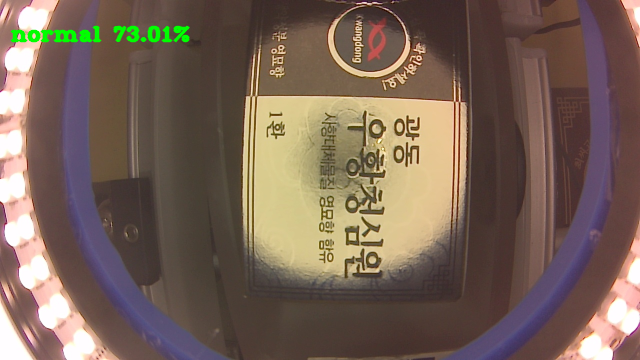

In [10]:
show_classification_result(img_path, predictor, classes_dict)

### Save trained model

In [11]:
model_dir = "model"
predictor.save(model_dir)
save_classes_dict(classes_dict, filename=os.path.join(model_dir, "classes_dict.json"))